# Анализ качества поиска в VK Видео

## Цель:
- Найти точки роста продукта: в каких случаях поиск показывает плохое качество?
- Используя визуализацию показать проблемные случаи
- Сформулировать краткие выводы на основе анализа

## Описание данных 
- user_id - идентификатор пользователя;
- sex - пол пользователя;
- age - возраст пользователя;
- platform - платформа;
- query_id - идентификатор поиска;
- query_text - текст введённого запроса пользователем;
- query_type - к какой теме относится запрос поиска: фильмы, шоу, новости или музыка;
- event - название события(действия, которое совершает пользователь), может принимать следующие значени:
 - tap - кликна айтем в выдаче поиска
 - like - поставил лайк
 - subscribe - подписка на автора
 - viev - просмотр видео/клипа/плейлиста
 - share - поделиться в сообщество/другу
 - search - событие поиска
 - click_position - позиция документа в выдаче поиска по которому совершенно событие (1 - первый элемент выдачи);
- doc_type - тип документа по которому совершенно событие: клипы, видео, плейлисты, автор;
- view_time - время просмотра видео/клипа/плейлиста.

## Загрузка библиотек и данных 
В этом блоке мы загружаем CSV-файл с данными о взаимодействии пользователей с поиском VK Видео, а также выполняем первичный обзор структуры таблицы: смотрим типы данных, первые строки и пропуски.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("https://davmedia.test.tech-mail.ru/editor_uploads/2025/04/03/analytics_test.csv")


Ознакомимся с данными


In [2]:
df.info()
df.describe()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      20000 non-null  int64 
 1   user_id         20000 non-null  int64 
 2   sex             20000 non-null  object
 3   age             20000 non-null  int64 
 4   platform        20000 non-null  object
 5   query_id        20000 non-null  int64 
 6   query_text      20000 non-null  object
 7   query_type      20000 non-null  object
 8   event           20000 non-null  object
 9   click_position  20000 non-null  int64 
 10  doc_type        15042 non-null  object
 11  view_time       20000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.8+ MB


,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time
0,0,96422511,female,68,android,89656828,передачи о новых технологиях,show,share,6,playlist,0
1,1,45247030,male,62,android_tv,89784877,автопрому новости,news,search,0,NaN,0
2,2,79572413,male,12,web,10555855,логистическое законодательство,news,search,0,NaN,0
3,3,821317,female,58,android_tv,72054848,банковские премии новости,news,search,0,NaN,0
4,4,6206023,female,24,android,20838049,вики шоу аманда,show,subscribe,7,author,0
5,5,8004249,anonym,0,android,19760211,как купить билеты на Грибов,music,tap,1,author,0
6,6,11617125,female,66,android_tv,59650610,5+1 шоу парень бедный,show,subscribe,8,video,0
7,7,79473329,anonym,0,smart_tv,569617620,биография Мэрилин Монро,films,tap,5,clip,0
8,8,17370723,anonym,0,android,46720550,поездка или поездочка шоу истории,show,subscribe,9,video,0
9,9,30126713,female,29,web,29645901,автозаконодательство новости,news,view,2,clip,183


Удалим лишний столбец 

In [3]:
df = df.drop(columns=['Unnamed: 0'])

Проверим на наличие дубликатов

In [4]:
df.duplicated().sum()

0


##  Создадим новый столбец «Плохой поиск»

 Предположим, что поиск считается неудачным в следующих случаях:
- Пользователь ничего не кликнул в выдаче.
- Клик был далеко (позиция выше 5).
- Пользователь не взаимодействовал с результатами (не смотрел, не лайкал и т.п.).

In [5]:
df['bad_search'] = (
    ((df['event'] == 'search') & (df['click_position'] == 0)) |
    ((df['event'] == 'tap') & (df['click_position'] > 5)) |
    ((df['view_time'] == 0) & (~df['event'].isin(['like', 'subscribe', 'view', 'share', 'tap'])))
)


Разобьём пользователей по возрастным группам для дальнейшего анализа.

In [6]:
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 25, 35, 50, 65, 100], labels=['<18', '18-25', '26-35', '36-50', '51-65', '65+'])


## Визуализация основных закономерностей

В этом блоке мы анализируем долю неудачных поисков:
- по платформам: web, android, android tv, smart tv, iphone;
- по возрасту пользователей: до 18, от 18 до 25, от 26 до 35, от 36 до 50, от 51 до 65, больше 65;
- по типу запроса: фильмы, музыка, шоу, новости;

Это позволяет выявить, для каких категорий пользователей и запросов поиск работает хуже всего.

Плохих поисков: 8985 из 20000 (44.9%)


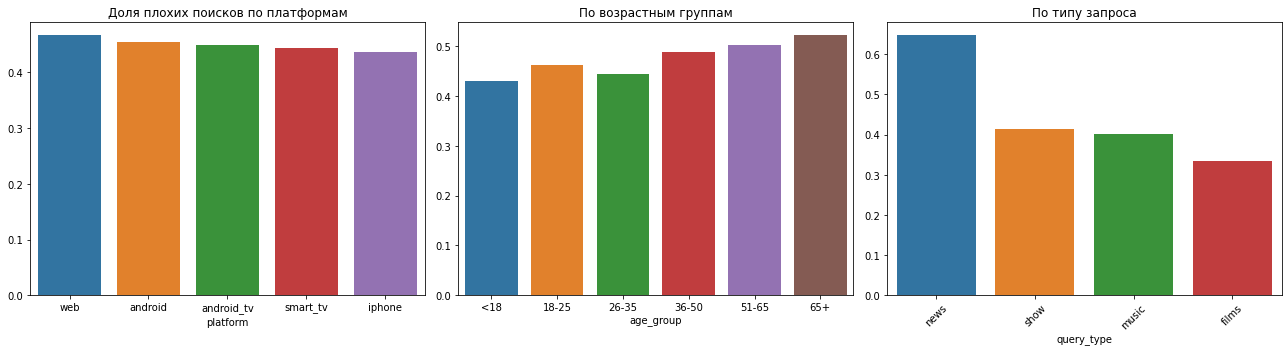

In [7]:
poor_search_count = df['bad_search'].sum()
total_searches = len(df)
poor_search_pct = poor_search_count / total_searches * 100
print(f"Плохих поисков: {poor_search_count} из {total_searches} ({poor_search_pct:.1f}%)")

platform_poor = df.groupby('platform')['bad_search'].mean().sort_values(ascending=False)
age_poor = df.groupby('age_group')['bad_search'].mean()
query_type_poor = df.groupby('query_type')['bad_search'].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x=platform_poor.index, y=platform_poor.values, ax=axes[0])
axes[0].set_title("Доля плохих поисков по платформам")

sns.barplot(x=age_poor.index, y=age_poor.values, ax=axes[1])
axes[1].set_title("По возрастным группам")

sns.barplot(x=query_type_poor.index, y=query_type_poor.values, ax=axes[2])
axes[2].set_title("По типу запроса")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Выводы:
- Почти 45% поисков можно считать неудачными.
- Проблемные платформы: Web, Android.
- Пользователи  старше 65лет сталкиваются с низким качеством выдачи.
- Хуже всего работает поиск по типу запроса "news".
